# Fashion MNIST

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline

In [2]:
from sklearn.datasets import fetch_openml
fashion_mnist = fetch_openml(data_id=40996) 

In [3]:
type(fashion_mnist)

sklearn.utils.Bunch

In [4]:
labels_s = '0 T-shirt/top \n1 Trouser \n2 Pullover \n3 Dress \n4 Coat \n5 Sandal \n6 Shirt \n7 Sneaker \n8 Bag \n9 Ankle boot'

fashion_label_translation = {
    int(k): v for k, v in [
        item.split(maxsplit=1) for item in labels_s.split('\n')
    ]
}

def translate_label(y, translation=fashion_label_translation):
    return pd.Series(y).apply(lambda y: translation[int(y)]).values

In [5]:
def display_fashion(img, target, ax):
    
    if len(img.shape):
        w = int(np.sqrt(img.shape[0]))
        img = img.reshape((w, w))
    
    ax.imshow(img, cmap='Greys')
    ax.set_title(f'{target}')
    ax.grid(False)

In [6]:
from sklearn.model_selection import train_test_split

fashion_mnist_sample = {}

fashion_mnist_sample['data'], _, fashion_mnist_sample['target'], _ = train_test_split(
    fashion_mnist['data'],
    fashion_mnist['target'],
    train_size = 10_000,
    random_state= 121,
)

x, y = fashion_mnist_sample['data'], fashion_mnist_sample['target']
x_train, x_test, y_train, y_test = train_test_split(
    x, 
    y, 
    test_size=0.2, 
    random_state=121,
)

In [7]:
from sklearn.preprocessing import MinMaxScaler

scaler =MinMaxScaler()

x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

In [8]:
y_train_translated = translate_label(y_train)
y_test_translated = translate_label(y_test)

In [9]:
y_test_translated

['Ankle boot', 'Dress ', 'Sneaker ', 'Sandal ', 'Dress ', ..., 'Trouser ', 'Bag ', 'Coat ', 'Bag ', 'Pullover ']
Length: 2000
Categories (10, object): ['T-shirt/top ', 'Trouser ', 'Pullover ', 'Dress ', ..., 'Shirt ', 'Sneaker ',
                          'Bag ', 'Ankle boot']

In [10]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
y_train_encoded = encoder.fit_transform(y_train_translated)
y_test_encoded = encoder.transform(y_test_translated)

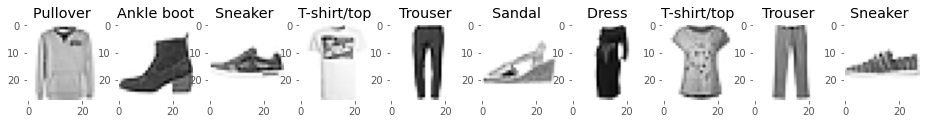

In [11]:
import random 

fig, axs = plt.subplots(1, 10, figsize=(16, 12))

for i in range(10):
    rand = random.choice(range(x_train.shape[0]))
    display_fashion(x_train[rand], y_train_translated[rand], axs[i])

fig.show()

In [13]:
from sklearn.neural_network import MLPClassifier

clf = MLPClassifier(hidden_layer_sizes=(100, 100), max_iter=500)
clf.fit(x_train, y_train_encoded)
y_pred = clf.predict(x_test)

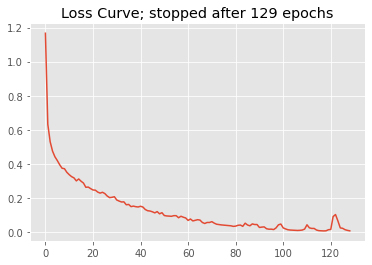

In [14]:
pd.Series(clf.loss_curve_).plot(
 title=f'Loss Curve; stopped after {clf.n_iter_} epochs'
)

1 0.1 0.01 0.001 0.0001 

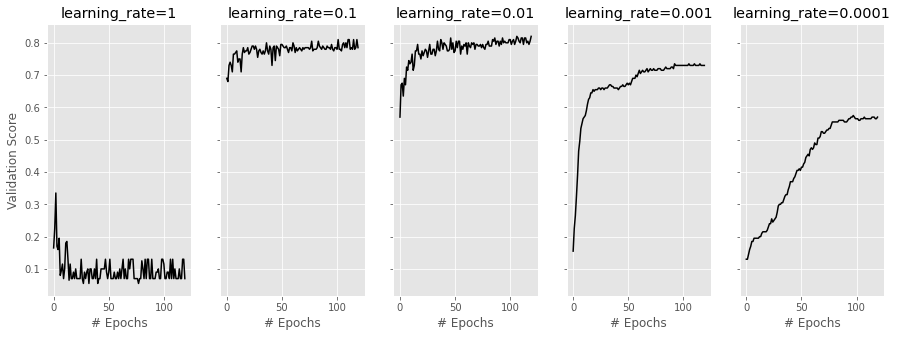

In [16]:
import warnings
from sklearn.exceptions import ConvergenceWarning

from sklearn.neural_network import MLPClassifier

learning_rate_init_options = [1, 0.1, 0.01, 0.001, 0.0001]

fig, axs = plt.subplots(1, len(learning_rate_init_options), figsize=(15, 5), sharex=True, sharey=True)

for i, learning_rate_init in enumerate(learning_rate_init_options):
    
    print(f'{learning_rate_init} ', end='')
    
    clf = MLPClassifier(
        hidden_layer_sizes=(500, ), 
        learning_rate='constant',
        learning_rate_init=learning_rate_init,
        validation_fraction=0.2,
        early_stopping=True, # Set to True to get clf.validation_scores_
        n_iter_no_change=120,
        momentum=0,
        max_iter=120, 
        solver='sgd',
        batch_size=25,
        verbose=0,
    )
    
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", category=ConvergenceWarning, module="sklearn")
        clf.fit(x_train[:1000,:], y_train_encoded[:1000])
        
    pd.Series(clf.validation_scores_).plot(
        title=f'learning_rate={learning_rate_init}', 
        kind='line', 
        color='k',
        ax=axs[i]
    )
    
    axs[i].set_xlabel('# Epochs')
    axs[i].set_ylabel('Validation Score')
    
fig.show()

100 1500 

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:612: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  "Got `batch_size` less than 1 or larger than "


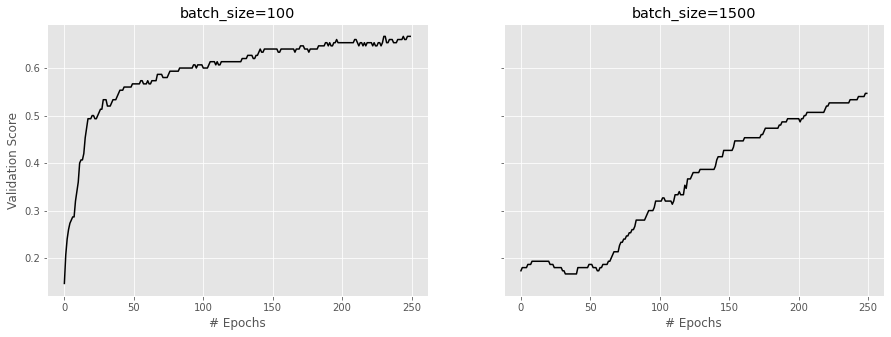

In [18]:
import warnings
from sklearn.exceptions import ConvergenceWarning

from sklearn.neural_network import MLPClassifier

# batch_sizes = [1, 10, 100, 1500]
batch_sizes = [100, 1500]

fig, axs = plt.subplots(1, len(batch_sizes), figsize=(15, 5), sharex=True, sharey=True)

for i, batch_size in enumerate(batch_sizes):
    
    print(f'{batch_size} ', end='')
    
    clf = MLPClassifier(
        hidden_layer_sizes=(500, ), 
        learning_rate='constant',
        learning_rate_init=0.001, 
        momentum=0,
        max_iter=250, 
        early_stopping=True,
        n_iter_no_change=250,
        solver='sgd',
        batch_size=batch_size,
        verbose=0,
    )
    
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", category=ConvergenceWarning, module="sklearn")
        clf.fit(x_train[:1500,:], y_train_encoded[:1500])
        
    # pd.Series(clf.loss_curve_).plot( 
    pd.Series(clf.validation_scores_).plot( 
        title=f'batch_size={batch_size}',
        color='k',
        kind='line', 
        ax=axs[i]
    )
    
    axs[i].set_xlabel('# Epochs')
    axs[i].set_ylabel('Validation Score')
    
fig.show()

In [19]:
from sklearn.model_selection import learning_curve

train_sizes = [1, 0.75, 0.5, 0.25, 0.1, 0.05]

train_sizes, train_scores, test_scores = learning_curve(
    MLPClassifier(
        hidden_layer_sizes=(100, 100), 
        solver='adam',
        early_stopping=False
    ), 
    x_train, y_train_encoded,
    train_sizes=train_sizes,
    scoring="precision_macro",
    cv=3,
    verbose=2,
    n_jobs=-1
)

[learning_curve] Training set sizes: [ 266  533 1333 2666 3999 5333]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 out of  18 | elapsed:  1.4min remaining:  1.4min
[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed:  3.2min finished


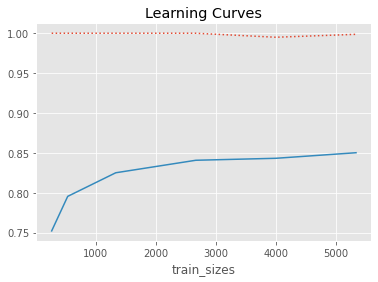

In [20]:
df_learning_curve = pd.DataFrame(
    {
        'train_sizes': train_sizes,
        'train_scores': train_scores.mean(axis=1),
        'test_scores': test_scores.mean(axis=1)
    }
).set_index('train_sizes')

df_learning_curve['train_scores'].plot(
    title='Learning Curves', ls=':',
)

df_learning_curve['test_scores'].plot(
    title='Learning Curves', ls='-',
)

In [21]:
from sklearn.model_selection import validation_curve

max_iter_range = [5, 10, 25, 50, 75, 100, 150]

train_scores, test_scores = validation_curve(
    MLPClassifier(
        hidden_layer_sizes=(100, 100), 
        solver='adam',
        early_stopping=False
    ), 
    x_train, y_train_encoded,
    param_name="max_iter", param_range=max_iter_range,
    scoring="precision_macro",
    cv=3,
    verbose=2,
    n_jobs=-1
)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  11 out of  21 | elapsed:  1.7min remaining:  1.5min
[Parallel(n_jobs=-1)]: Done  21 out of  21 | elapsed:  3.4min finished


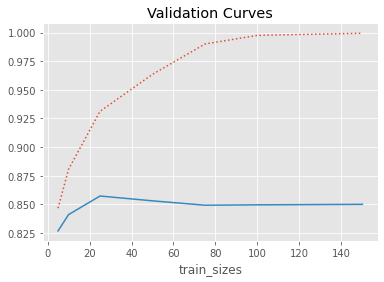

In [28]:
df_validation_curve = pd.DataFrame(
    {
        'train_sizes': max_iter_range,
        'train_scores': train_scores.mean(axis=1),
        'test_scores': test_scores.mean(axis=1)
    }
).set_index('train_sizes')

df_validation_curve['train_scores'].plot(
    title='Validation Curves', ls=':',
)

df_validation_curve['test_scores'].plot(
    title='Validation Curves', ls='-',
)

In [22]:
def relu(X):
    return np.clip(X, 0, np.finfo(X.dtype).max)

def inplace_relu_derivative(Z, delta):
    delta[Z == 0] = 0

In [23]:
leaky_relu_slope = 0.01

def leaky_relu(X):
    X_min = leaky_relu_slope * np.array(X)
    return np.clip(X, X_min, np.finfo(X.dtype).max)

def inplace_leaky_relu_derivative(Z, delta):
    delta[Z < 0] = leaky_relu_slope * delta[Z < 0]

In [24]:
from sklearn.neural_network._base import ACTIVATIONS, DERIVATIVES

ACTIVATIONS['leaky_relu'] = leaky_relu
DERIVATIVES['leaky_relu'] = inplace_leaky_relu_derivative

In [25]:
clf = MLPClassifier(activation='leaky_relu')